# Training Experiments: Image Deblurring

This notebook is for **interactive experimentation** with training configurations:
- Test different loss functions (L1, MSE, Charbonnier)
- Tune hyperparameters (learning rate, batch size, weight decay)
- Sanity check: Overfit on small dataset
- Visualize training progress in real-time
- Debug and iterate quickly

For production training runs, use `src/train.py` script.

## 1. Import Required Libraries

In [1]:
import os
import sys
import random
import importlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Add src to path
sys.path.append('.')

import src.dataset
import src.models.unet
import src.models.lightunet
import src.utils.metrics

# Reload modules to pick up changes
importlib.reload(src.dataset)
importlib.reload(src.models.unet)
importlib.reload(src.models.lightunet)
importlib.reload(src.utils.metrics)

from src.dataset import GoProDataset, get_dataloaders, get_image_pairs
from src.models.unet import SimpleUNet
from src.models.lightunet import LightweightUNet
from src.utils.metrics import calculate_psnr, PSNRMetric

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✓ Random seeds set for reproducibility")

/Users/Gabriel/dev/konkuk/IA/project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1
CUDA available: False
MPS available: True
✓ Random seeds set for reproducibility


## 2. Device Setup

Configure which device to use for training (CUDA, MPS for Apple Silicon, or CPU).

In [2]:
# Determine device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU (MPS)")
else:
    device = torch.device('cpu')
    print("Using CPU (training will be slow!)")

print(f"\nDevice: {device}")

Using Apple Silicon GPU (MPS)

Device: mps


## 3. Training Configuration

Set all hyperparameters in one place for easy experimentation.

In [ ]:
class Config:
    """Training configuration - modify these for experiments"""
    
    # Data
    data_root = './data'
    patch_size = 256        # Crop size for training
    batch_size = 16          # Increased to 16 for full training (reduce to 4 if OOM)
    num_workers = 0         # Use workers for faster data loading
    
    # Model
    in_channels = 3
    out_channels = 3
    
    # Training
    num_epochs = 150        # Standard run
    learning_rate = 2e-4    # Stable LR for residual learning
    weight_decay = 1e-3     # Add slight regularization to prevent overfitting
    
    # Loss function
    loss_type = 'charbonnier'
    
    # Scheduler
    scheduler_patience = 10
    scheduler_factor = 0.5
    
    # Checkpointing
    save_dir = './experiments'
    experiment_name = 'revised_simple_unet_full'
    
    # Early stopping
    early_stop_patience = 20
    
    # Sanity check mode
    sanity_check = False    # DISABLED: We are doing real training now!
    sanity_check_samples = 10

config = Config()

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)
experiment_dir = os.path.join(config.save_dir, config.experiment_name)
os.makedirs(experiment_dir, exist_ok=True)

print("Configuration:")
for key in dir(config):
    if not key.startswith('_'):
        value = getattr(config, key)
        print(f"  {key}: {value}")
print("\n🚀 FULL TRAINING PHASE:")
print("   - Dataset: Full GoPro Train (2103 images)")
print("   - Augmentation: ENABLED (Random Crop, Flip)")
print("   - Validation: Unseen Test Set")
print("   - Goal: Val PSNR > 28 dB")

Configuration:
  batch_size: 16
  data_root: ./data
  early_stop_patience: 20
  experiment_name: simple_unet_full
  in_channels: 3
  learning_rate: 0.0002
  loss_type: charbonnier
  num_epochs: 150
  num_workers: 0
  out_channels: 3
  patch_size: 256
  sanity_check: False
  sanity_check_samples: 10
  save_dir: ./experiments
  scheduler_factor: 0.5
  scheduler_patience: 10
  weight_decay: 0.0001

🚀 FULL TRAINING PHASE:
   - Dataset: Full GoPro Train (2103 images)
   - Augmentation: ENABLED (Random Crop, Flip)
   - Validation: Unseen Test Set
   - Goal: Val PSNR > 28 dB


## 4. Loss Functions

Compare different loss functions for image deblurring:
- **L1 Loss** (MAE): Robust to outliers, produces sharper images
- **MSE Loss** (L2): Smooth results but can be blurry
- **Charbonnier Loss**: Smooth L1, combines benefits of both

In [4]:
class CharbonnierLoss(nn.Module):
    """
    Charbonnier Loss (smooth L1 loss).
    
    Loss = sqrt(||x - y||^2 + epsilon^2)
    
    Behaves like L1 for large errors, L2 for small errors.
    Often works better than pure L1 or L2 for image reconstruction.
    """
    def __init__(self, epsilon=1e-3):
        super().__init__()
        self.epsilon = epsilon
    
    def forward(self, pred, target):
        diff = pred - target
        loss = torch.sqrt(diff * diff + self.epsilon * self.epsilon)
        return loss.mean()


def get_loss_function(loss_type='l1'):
    """Get loss function by name."""
    if loss_type == 'l1':
        return nn.L1Loss()
    elif loss_type == 'mse':
        return nn.MSELoss()
    elif loss_type == 'charbonnier':
        return CharbonnierLoss()
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")


# Test the loss functions
test_pred = torch.randn(1, 3, 256, 256)
test_target = torch.randn(1, 3, 256, 256)

for loss_name in ['l1', 'mse', 'charbonnier']:
    loss_fn = get_loss_function(loss_name)
    loss_value = loss_fn(test_pred, test_target)
    print(f"{loss_name.upper():15s} loss: {loss_value.item():.6f}")

print("\n✓ Loss functions ready")

L1              loss: 1.130723
MSE             loss: 2.010360
CHARBONNIER     loss: 1.130726

✓ Loss functions ready


## 5. Load Data

Load the GoPro dataset. For sanity check mode, we'll use only a few images.

In [5]:
# Get image paths
train_blur, train_sharp = get_image_pairs(config.data_root, 'train')
test_blur, test_sharp = get_image_pairs(config.data_root, 'test')

print(f"Total training pairs: {len(train_blur)}")
print(f"Total test pairs: {len(test_blur)}")

# Sanity check mode logic
if config.sanity_check:
    train_blur = train_blur[:config.sanity_check_samples]
    train_sharp = train_sharp[:config.sanity_check_samples]
    test_blur = train_blur 
    test_sharp = train_sharp
    print(f"\n🔬 SANITY CHECK MODE: Using {len(train_blur)} training samples")

# Create datasets
# Dynamic is_train flag: True for full training, False for sanity check
train_dataset = GoProDataset(
    train_blur, 
    train_sharp, 
    patch_size=config.patch_size, 
    is_train=not config.sanity_check  # ENABLE augmentation for full training
)

val_dataset = GoProDataset(
    test_blur, 
    test_sharp, 
    patch_size=config.patch_size, 
    is_train=False  # Always False for validation (center crop)
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=not config.sanity_check,  # Shuffle for full training
    num_workers=config.num_workers,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\nTrain batches per epoch: {len(train_loader)}")
print(f"Val batches per epoch: {len(val_loader)}")

if not config.sanity_check:
    print("\n✅ FULL TRAINING MODE:")
    print("   - Random Cropping: ON")
    print("   - Random Flipping: ON")
    print("   - Shuffling: ON")
else:
    print("\n⚠️ SANITY CHECK MODE: Augmentation disabled")

print("✓ Data loaded")

Total training pairs: 2103
Total test pairs: 1111

Train batches per epoch: 132
Val batches per epoch: 70

✅ FULL TRAINING MODE:
   - Random Cropping: ON
   - Random Flipping: ON
   - Shuffling: ON
✓ Data loaded


## 6. Create Model

Initialize the U-Net model and move it to the device.

In [ ]:
# # Initialize model with Global Residual Learning
# model = SimpleUNet(
#     in_channels=config.in_channels,
#     out_channels=config.out_channels,
#     global_residual=True  # Enable residual learning (Output = Input + Residual)
# ).to(device)

model = LightweightUNet(
    in_channels=config.in_channels,
    out_channels=config.out_channels,
    global_residual=True, # Enable residual learning (Output = Input + Residual)
    start_filters=48 # 32->48 for deeper understanding
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: SimpleUNet (Global Residual: {model.global_residual})")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model on device: {next(model.parameters()).device}")

# Verify Zero Initialization
if model.global_residual:
    # Check if output layer weights are close to zero
    out_weight_mean = model.output.weight.abs().mean().item()
    print(f"Output layer weight mean: {out_weight_mean:.6f} (Should be ~0.0)")
    print("✓ Zero initialization verified - Model starts as Identity Mapping")

print("✓ Model ready")

Model: SimpleUNet (Global Residual: True)
Total parameters: 3,021,662
Trainable parameters: 3,021,662
Model on device: mps:0
Output layer weight mean: 0.000000 (Should be ~0.0)
✓ Zero initialization verified - Model starts as Identity Mapping
✓ Model ready
Output layer weight mean: 0.000000 (Should be ~0.0)
✓ Zero initialization verified - Model starts as Identity Mapping
✓ Model ready


## 7. Setup Optimizer and Scheduler

Configure Adam optimizer with weight decay and learning rate scheduler.

In [ ]:
# Loss function
criterion = get_loss_function(config.loss_type)
print(f"Loss function: {config.loss_type.upper()}")

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
print(f"Optimizer: Adam (lr={config.learning_rate}, weight_decay={config.weight_decay})")

# Learning rate scheduler - reduces LR when validation loss plateaus
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='max',  # Maximize PSNR
#     factor=config.scheduler_factor,
#     patience=config.scheduler_patience,
# )

# Remplace ton bloc scheduler par celui-ci :
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.num_epochs, # Il atteindra 0 à la toute dernière epoch
    eta_min=1e-6             # Le LR minimum (ne descend pas à 0 absolu)
)

print("Scheduler: CosineAnnealingLR (Force la convergence)")
print(f"Scheduler: ReduceLROnPlateau (patience={config.scheduler_patience})")
print("✓ Training setup complete")

Loss function: CHARBONNIER
Optimizer: Adam (lr=0.0002, weight_decay=0.0001)
Scheduler: ReduceLROnPlateau (patience=10)
✓ Training setup complete


## 8. Training and Validation Functions

In [8]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, disable_tqdm=False):
    """Train for one epoch."""
    model.train()
    
    running_loss = 0.0
    psnr_metric = PSNRMetric()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", disable=disable_tqdm)
    
    for batch_idx, (blur, sharp) in enumerate(pbar):
        # Move to device
        blur = blur.to(device)
        sharp = sharp.to(device)
        
        # Forward pass
        output = model(blur)
        loss = criterion(output, sharp)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Metrics
        running_loss += loss.item()
        psnr_metric.update(output.detach(), sharp)
        
        # Update progress bar
        if not disable_tqdm:
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'psnr': f"{psnr_metric.compute():.2f}"
            })
    
    avg_loss = running_loss / len(train_loader)
    avg_psnr = psnr_metric.compute()
    
    return avg_loss, avg_psnr


def validate(model, val_loader, criterion, device, epoch, disable_tqdm=False):
    """Validate the model."""
    model.eval()
    
    running_loss = 0.0
    psnr_metric = PSNRMetric()
    
    pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]  ", disable=disable_tqdm)
    
    with torch.no_grad():
        for blur, sharp in pbar:
            # Move to device
            blur = blur.to(device)
            sharp = sharp.to(device)
            
            # Forward pass
            output = model(blur)
            loss = criterion(output, sharp)
            
            # Metrics
            running_loss += loss.item()
            psnr_metric.update(output, sharp)
            
            # Update progress bar
            if not disable_tqdm:
                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'psnr': f"{psnr_metric.compute():.2f}"
                })
    
    avg_loss = running_loss / len(val_loader)
    avg_psnr = psnr_metric.compute()
    
    return avg_loss, avg_psnr


print("✓ Training functions defined")

✓ Training functions defined


## 9. Main Training Loop

Train the model with early stopping and checkpointing.

In [9]:
# Training history
history = {
    'train_loss': [],
    'train_psnr': [],
    'val_loss': [],
    'val_psnr': [],
    'lr': []
}

# Early stopping
best_psnr = 0.0
epochs_without_improvement = 0

print("Starting training...")
print("=" * 70)

for epoch in range(config.num_epochs):
    torch.mps.empty_cache()  # Clear MPS cache to prevent OOM
    # Train
    train_loss, train_psnr = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch, disable_tqdm=False
    )
    
    # Validate
    val_loss, val_psnr = validate(
        model, val_loader, criterion, device, epoch, disable_tqdm=False
    )
    
    # Update learning rate scheduler
    scheduler.step(val_psnr)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_psnr'].append(train_psnr)
    history['val_loss'].append(val_loss)
    history['val_psnr'].append(val_psnr)
    history['lr'].append(current_lr)
    
    # Print epoch summary (every 10 epochs to avoid crashing VS Code)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train PSNR: {train_psnr:.2f} dB")
        print(f"  Val Loss:   {val_loss:.4f} | Val PSNR:   {val_psnr:.2f} dB")
        print(f"  LR: {current_lr:.2e}")
    
    # Save best model
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        epochs_without_improvement = 0
        
        # Save checkpoint
        checkpoint_path = os.path.join(experiment_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_psnr': best_psnr,
            'config': vars(config)
        }, checkpoint_path)
        print(f"{epoch}/{config.num_epochs}")
        print(f"  ✓ Saved best model (PSNR: {best_psnr:.2f} dB)")
    else:
        epochs_without_improvement += 1
        print(f"  No improvement for {epochs_without_improvement} epoch(s)")
    
    # Early stopping
    if epochs_without_improvement >= config.early_stop_patience:
        print(f"\n🛑 Early stopping triggered after {epoch+1} epochs")
        print(f"Best PSNR: {best_psnr:.2f} dB")
        break
    
    print("=" * 70)

print("\n✅ Training complete!")
print(f"Best validation PSNR: {best_psnr:.2f} dB")

Starting training...


Epoch 1 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0450, psnr=25.77]




Epoch 1/150
  Train Loss: 0.0327 | Train PSNR: 26.98 dB
  Val Loss:   0.0360 | Val PSNR:   25.77 dB
  LR: 2.00e-04
0/150
  ✓ Saved best model (PSNR: 25.77 dB)


Epoch 2 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0442, psnr=25.79]



1/150
  ✓ Saved best model (PSNR: 25.79 dB)


Epoch 3 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0434, psnr=25.87]



2/150
  ✓ Saved best model (PSNR: 25.87 dB)


Epoch 4 [Val]  : 100%|██████████| 70/70 [01:00<00:00,  1.16it/s, loss=0.0430, psnr=25.85]



  No improvement for 1 epoch(s)


Epoch 5 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0422, psnr=25.97]




Epoch 5/150
  Train Loss: 0.0311 | Train PSNR: 27.28 dB
  Val Loss:   0.0347 | Val PSNR:   25.97 dB
  LR: 2.00e-04
4/150
  ✓ Saved best model (PSNR: 25.97 dB)


Epoch 6 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.27it/s, loss=0.0419, psnr=25.95]



  No improvement for 1 epoch(s)


Epoch 7 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0409, psnr=25.98]



6/150
  ✓ Saved best model (PSNR: 25.98 dB)


Epoch 8 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0413, psnr=26.05]



7/150
  ✓ Saved best model (PSNR: 26.05 dB)


Epoch 9 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0415, psnr=26.05]



  No improvement for 1 epoch(s)


Epoch 10 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0402, psnr=26.11]




Epoch 10/150
  Train Loss: 0.0306 | Train PSNR: 27.36 dB
  Val Loss:   0.0339 | Val PSNR:   26.11 dB
  LR: 2.00e-04
9/150
  ✓ Saved best model (PSNR: 26.11 dB)


Epoch 11 [Val]  : 100%|██████████| 70/70 [00:56<00:00,  1.25it/s, loss=0.0404, psnr=26.16]



10/150
  ✓ Saved best model (PSNR: 26.16 dB)


Epoch 12 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0409, psnr=26.15]



  No improvement for 1 epoch(s)


Epoch 13 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0397, psnr=26.21]



12/150
  ✓ Saved best model (PSNR: 26.21 dB)


Epoch 14 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0392, psnr=26.18]



  No improvement for 1 epoch(s)


Epoch 15 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0397, psnr=26.20]




Epoch 15/150
  Train Loss: 0.0294 | Train PSNR: 27.67 dB
  Val Loss:   0.0336 | Val PSNR:   26.20 dB
  LR: 2.00e-04
  No improvement for 2 epoch(s)


Epoch 16 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0386, psnr=26.28]



15/150
  ✓ Saved best model (PSNR: 26.28 dB)


Epoch 17 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.30it/s, loss=0.0385, psnr=26.31]



16/150
  ✓ Saved best model (PSNR: 26.31 dB)


Epoch 18 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0377, psnr=26.29]



  No improvement for 1 epoch(s)


Epoch 19 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0384, psnr=26.31]



18/150
  ✓ Saved best model (PSNR: 26.31 dB)


Epoch 20 [Val]  : 100%|██████████| 70/70 [00:53<00:00,  1.30it/s, loss=0.0377, psnr=26.33]




Epoch 20/150
  Train Loss: 0.0289 | Train PSNR: 27.77 dB
  Val Loss:   0.0329 | Val PSNR:   26.33 dB
  LR: 2.00e-04
19/150
  ✓ Saved best model (PSNR: 26.33 dB)


Epoch 21 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0378, psnr=26.35]



20/150
  ✓ Saved best model (PSNR: 26.35 dB)


Epoch 22 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.27it/s, loss=0.0370, psnr=26.35]



21/150
  ✓ Saved best model (PSNR: 26.35 dB)


Epoch 23 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.27it/s, loss=0.0372, psnr=26.40]



22/150
  ✓ Saved best model (PSNR: 26.40 dB)


Epoch 24 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0372, psnr=26.40]



23/150
  ✓ Saved best model (PSNR: 26.40 dB)


Epoch 25 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0369, psnr=26.44]




Epoch 25/150
  Train Loss: 0.0286 | Train PSNR: 27.94 dB
  Val Loss:   0.0324 | Val PSNR:   26.44 dB
  LR: 2.00e-04
24/150
  ✓ Saved best model (PSNR: 26.44 dB)


Epoch 26 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0368, psnr=26.51]



25/150
  ✓ Saved best model (PSNR: 26.51 dB)


Epoch 27 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0370, psnr=26.47]



  No improvement for 1 epoch(s)


Epoch 28 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0366, psnr=26.52]



27/150
  ✓ Saved best model (PSNR: 26.52 dB)


Epoch 29 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0367, psnr=26.52]



28/150
  ✓ Saved best model (PSNR: 26.52 dB)


Epoch 30 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0363, psnr=26.53]




Epoch 30/150
  Train Loss: 0.0279 | Train PSNR: 28.09 dB
  Val Loss:   0.0320 | Val PSNR:   26.53 dB
  LR: 2.00e-04
29/150
  ✓ Saved best model (PSNR: 26.53 dB)


Epoch 31 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0373, psnr=26.54]



30/150
  ✓ Saved best model (PSNR: 26.54 dB)


Epoch 32 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0357, psnr=26.59]



31/150
  ✓ Saved best model (PSNR: 26.59 dB)


Epoch 33 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.30it/s, loss=0.0364, psnr=26.54]



  No improvement for 1 epoch(s)


Epoch 34 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0363, psnr=26.60]



33/150
  ✓ Saved best model (PSNR: 26.60 dB)


Epoch 35 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0359, psnr=26.51]




Epoch 35/150
  Train Loss: 0.0275 | Train PSNR: 28.13 dB
  Val Loss:   0.0320 | Val PSNR:   26.51 dB
  LR: 2.00e-04
  No improvement for 1 epoch(s)


Epoch 36 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0352, psnr=26.59]



  No improvement for 2 epoch(s)


Epoch 37 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0364, psnr=26.66]



36/150
  ✓ Saved best model (PSNR: 26.66 dB)


Epoch 38 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0374, psnr=26.56]



  No improvement for 1 epoch(s)


Epoch 39 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0356, psnr=26.67]



38/150
  ✓ Saved best model (PSNR: 26.67 dB)


Epoch 40 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0355, psnr=26.70]




Epoch 40/150
  Train Loss: 0.0272 | Train PSNR: 28.23 dB
  Val Loss:   0.0313 | Val PSNR:   26.70 dB
  LR: 2.00e-04
39/150
  ✓ Saved best model (PSNR: 26.70 dB)


Epoch 41 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0356, psnr=26.68]



  No improvement for 1 epoch(s)


Epoch 42 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.27it/s, loss=0.0354, psnr=26.70]



41/150
  ✓ Saved best model (PSNR: 26.70 dB)


Epoch 43 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.30it/s, loss=0.0347, psnr=26.78]



42/150
  ✓ Saved best model (PSNR: 26.78 dB)


Epoch 44 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0345, psnr=26.72]



  No improvement for 1 epoch(s)


Epoch 45 [Val]  : 100%|██████████| 70/70 [00:53<00:00,  1.30it/s, loss=0.0352, psnr=26.74]




Epoch 45/150
  Train Loss: 0.0274 | Train PSNR: 28.21 dB
  Val Loss:   0.0311 | Val PSNR:   26.74 dB
  LR: 2.00e-04
  No improvement for 2 epoch(s)


Epoch 46 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0344, psnr=26.78]



45/150
  ✓ Saved best model (PSNR: 26.78 dB)


Epoch 47 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.27it/s, loss=0.0343, psnr=26.78]



  No improvement for 1 epoch(s)


Epoch 48 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0347, psnr=26.81]



47/150
  ✓ Saved best model (PSNR: 26.81 dB)


Epoch 49 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0340, psnr=26.83]



48/150
  ✓ Saved best model (PSNR: 26.83 dB)


Epoch 50 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0340, psnr=26.83]




Epoch 50/150
  Train Loss: 0.0268 | Train PSNR: 28.28 dB
  Val Loss:   0.0309 | Val PSNR:   26.83 dB
  LR: 2.00e-04
  No improvement for 1 epoch(s)


Epoch 51 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0346, psnr=26.77]



  No improvement for 2 epoch(s)


Epoch 52 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0342, psnr=26.84]



51/150
  ✓ Saved best model (PSNR: 26.84 dB)


Epoch 53 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.30it/s, loss=0.0341, psnr=26.86]



52/150
  ✓ Saved best model (PSNR: 26.86 dB)


Epoch 54 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0338, psnr=26.81]



  No improvement for 1 epoch(s)


Epoch 55 [Val]  : 100%|██████████| 70/70 [01:00<00:00,  1.15it/s, loss=0.0344, psnr=26.86]




Epoch 55/150
  Train Loss: 0.0268 | Train PSNR: 28.38 dB
  Val Loss:   0.0307 | Val PSNR:   26.86 dB
  LR: 2.00e-04
  No improvement for 2 epoch(s)


Epoch 56 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0337, psnr=26.91]



55/150
  ✓ Saved best model (PSNR: 26.91 dB)


Epoch 57 [Val]  : 100%|██████████| 70/70 [00:53<00:00,  1.30it/s, loss=0.0337, psnr=26.83]



  No improvement for 1 epoch(s)


Epoch 58 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0338, psnr=26.90]



  No improvement for 2 epoch(s)


Epoch 59 [Val]  : 100%|██████████| 70/70 [00:53<00:00,  1.30it/s, loss=0.0334, psnr=26.89]



  No improvement for 3 epoch(s)


Epoch 60 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0333, psnr=26.91]




Epoch 60/150
  Train Loss: 0.0263 | Train PSNR: 28.51 dB
  Val Loss:   0.0305 | Val PSNR:   26.91 dB
  LR: 2.00e-04
59/150
  ✓ Saved best model (PSNR: 26.91 dB)


Epoch 61 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0338, psnr=26.95]



60/150
  ✓ Saved best model (PSNR: 26.95 dB)


Epoch 62 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0338, psnr=26.97]



61/150
  ✓ Saved best model (PSNR: 26.97 dB)


Epoch 63 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0330, psnr=27.00]



62/150
  ✓ Saved best model (PSNR: 27.00 dB)


Epoch 64 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0335, psnr=27.00]



63/150
  ✓ Saved best model (PSNR: 27.00 dB)


Epoch 65 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.25it/s, loss=0.0336, psnr=27.00]




Epoch 65/150
  Train Loss: 0.0262 | Train PSNR: 28.54 dB
  Val Loss:   0.0302 | Val PSNR:   27.00 dB
  LR: 2.00e-04
  No improvement for 1 epoch(s)


Epoch 66 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0333, psnr=26.99]



  No improvement for 2 epoch(s)


Epoch 67 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.26it/s, loss=0.0335, psnr=26.92]



  No improvement for 3 epoch(s)


Epoch 68 [Val]  : 100%|██████████| 70/70 [00:58<00:00,  1.19it/s, loss=0.0335, psnr=26.94]



  No improvement for 4 epoch(s)


Epoch 69 [Val]  : 100%|██████████| 70/70 [00:53<00:00,  1.30it/s, loss=0.0330, psnr=27.05]



68/150
  ✓ Saved best model (PSNR: 27.05 dB)


Epoch 70 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0329, psnr=27.00]




Epoch 70/150
  Train Loss: 0.0262 | Train PSNR: 28.59 dB
  Val Loss:   0.0301 | Val PSNR:   27.00 dB
  LR: 2.00e-04
  No improvement for 1 epoch(s)


Epoch 71 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0331, psnr=27.07]



70/150
  ✓ Saved best model (PSNR: 27.07 dB)


Epoch 72 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0335, psnr=27.01]



  No improvement for 1 epoch(s)


Epoch 73 [Val]  : 100%|██████████| 70/70 [00:53<00:00,  1.30it/s, loss=0.0328, psnr=27.08]



72/150
  ✓ Saved best model (PSNR: 27.08 dB)


Epoch 74 [Val]  : 100%|██████████| 70/70 [00:57<00:00,  1.22it/s, loss=0.0331, psnr=27.04]



  No improvement for 1 epoch(s)


Epoch 75 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0320, psnr=27.10]




Epoch 75/150
  Train Loss: 0.0258 | Train PSNR: 28.69 dB
  Val Loss:   0.0298 | Val PSNR:   27.10 dB
  LR: 2.00e-04
74/150
  ✓ Saved best model (PSNR: 27.10 dB)


Epoch 76 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0329, psnr=27.09]



  No improvement for 1 epoch(s)


Epoch 77 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0328, psnr=27.08]



  No improvement for 2 epoch(s)


Epoch 78 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0326, psnr=27.13]



77/150
  ✓ Saved best model (PSNR: 27.13 dB)


Epoch 79 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0324, psnr=27.14]



78/150
  ✓ Saved best model (PSNR: 27.14 dB)


Epoch 80 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0324, psnr=27.16]




Epoch 80/150
  Train Loss: 0.0257 | Train PSNR: 28.72 dB
  Val Loss:   0.0296 | Val PSNR:   27.16 dB
  LR: 2.00e-04
79/150
  ✓ Saved best model (PSNR: 27.16 dB)


Epoch 81 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0326, psnr=27.12]



  No improvement for 1 epoch(s)


Epoch 82 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0324, psnr=27.11]



  No improvement for 2 epoch(s)


Epoch 83 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0324, psnr=27.17]



82/150
  ✓ Saved best model (PSNR: 27.17 dB)


Epoch 84 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0336, psnr=27.05]



  No improvement for 1 epoch(s)


Epoch 85 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0321, psnr=27.21]




Epoch 85/150
  Train Loss: 0.0254 | Train PSNR: 28.83 dB
  Val Loss:   0.0295 | Val PSNR:   27.21 dB
  LR: 2.00e-04
84/150
  ✓ Saved best model (PSNR: 27.21 dB)


Epoch 86 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0319, psnr=27.20]



  No improvement for 1 epoch(s)


Epoch 87 [Val]  : 100%|██████████| 70/70 [00:59<00:00,  1.18it/s, loss=0.0323, psnr=27.15]



  No improvement for 2 epoch(s)


Epoch 88 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0318, psnr=27.19]



  No improvement for 3 epoch(s)


Epoch 89 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0329, psnr=27.13]



  No improvement for 4 epoch(s)


Epoch 90 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0318, psnr=27.16]




Epoch 90/150
  Train Loss: 0.0256 | Train PSNR: 28.69 dB
  Val Loss:   0.0296 | Val PSNR:   27.16 dB
  LR: 2.00e-04
  No improvement for 5 epoch(s)


Epoch 91 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0315, psnr=27.26]



90/150
  ✓ Saved best model (PSNR: 27.26 dB)


Epoch 92 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.30it/s, loss=0.0320, psnr=27.25]



  No improvement for 1 epoch(s)


Epoch 93 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0319, psnr=27.23]



  No improvement for 2 epoch(s)


Epoch 94 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.30it/s, loss=0.0323, psnr=27.23]



  No improvement for 3 epoch(s)


Epoch 95 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0317, psnr=27.27]




Epoch 95/150
  Train Loss: 0.0258 | Train PSNR: 28.65 dB
  Val Loss:   0.0292 | Val PSNR:   27.27 dB
  LR: 2.00e-04
94/150
  ✓ Saved best model (PSNR: 27.27 dB)


Epoch 96 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0320, psnr=27.22]



  No improvement for 1 epoch(s)


Epoch 97 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0329, psnr=27.14]



  No improvement for 2 epoch(s)


Epoch 98 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0316, psnr=27.21]



  No improvement for 3 epoch(s)


Epoch 99 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0320, psnr=27.25]



  No improvement for 4 epoch(s)


Epoch 100 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0315, psnr=27.26]




Epoch 100/150
  Train Loss: 0.0256 | Train PSNR: 28.74 dB
  Val Loss:   0.0292 | Val PSNR:   27.26 dB
  LR: 2.00e-04
  No improvement for 5 epoch(s)


Epoch 101 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0313, psnr=27.25]



  No improvement for 6 epoch(s)


Epoch 102 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0317, psnr=27.32]



101/150
  ✓ Saved best model (PSNR: 27.32 dB)


Epoch 103 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0311, psnr=27.27]



  No improvement for 1 epoch(s)


Epoch 104 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0321, psnr=27.13]



  No improvement for 2 epoch(s)


Epoch 105 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0316, psnr=27.29]




Epoch 105/150
  Train Loss: 0.0253 | Train PSNR: 28.77 dB
  Val Loss:   0.0292 | Val PSNR:   27.29 dB
  LR: 2.00e-04
  No improvement for 3 epoch(s)


Epoch 106 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0317, psnr=27.33]



105/150
  ✓ Saved best model (PSNR: 27.33 dB)


Epoch 107 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0319, psnr=27.34]



106/150
  ✓ Saved best model (PSNR: 27.34 dB)


Epoch 108 [Val]  : 100%|██████████| 70/70 [00:53<00:00,  1.30it/s, loss=0.0315, psnr=27.39]



107/150
  ✓ Saved best model (PSNR: 27.39 dB)


Epoch 109 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0313, psnr=27.36]



  No improvement for 1 epoch(s)


Epoch 110 [Val]  : 100%|██████████| 70/70 [01:02<00:00,  1.12it/s, loss=0.0315, psnr=27.39]




Epoch 110/150
  Train Loss: 0.0251 | Train PSNR: 28.98 dB
  Val Loss:   0.0288 | Val PSNR:   27.39 dB
  LR: 2.00e-04
109/150
  ✓ Saved best model (PSNR: 27.39 dB)


Epoch 111 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.26it/s, loss=0.0320, psnr=27.35]



  No improvement for 1 epoch(s)


Epoch 112 [Val]  : 100%|██████████| 70/70 [00:58<00:00,  1.19it/s, loss=0.0316, psnr=27.29]



  No improvement for 2 epoch(s)


Epoch 113 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0314, psnr=27.39]



112/150
  ✓ Saved best model (PSNR: 27.39 dB)


Epoch 114 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0309, psnr=27.35]



  No improvement for 1 epoch(s)


Epoch 115 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.27it/s, loss=0.0316, psnr=27.40]




Epoch 115/150
  Train Loss: 0.0250 | Train PSNR: 28.81 dB
  Val Loss:   0.0288 | Val PSNR:   27.40 dB
  LR: 2.00e-04
114/150
  ✓ Saved best model (PSNR: 27.40 dB)


Epoch 116 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0310, psnr=27.41]



115/150
  ✓ Saved best model (PSNR: 27.41 dB)


Epoch 117 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.27it/s, loss=0.0316, psnr=27.32]



  No improvement for 1 epoch(s)


Epoch 118 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0312, psnr=27.40]



  No improvement for 2 epoch(s)


Epoch 119 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0313, psnr=27.39]



  No improvement for 3 epoch(s)


Epoch 120 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0313, psnr=27.39]




Epoch 120/150
  Train Loss: 0.0248 | Train PSNR: 28.97 dB
  Val Loss:   0.0287 | Val PSNR:   27.39 dB
  LR: 2.00e-04
  No improvement for 4 epoch(s)


Epoch 121 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0305, psnr=27.46]



120/150
  ✓ Saved best model (PSNR: 27.46 dB)


Epoch 122 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0310, psnr=27.42]



  No improvement for 1 epoch(s)


Epoch 123 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.30it/s, loss=0.0311, psnr=27.38]



  No improvement for 2 epoch(s)


Epoch 124 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.26it/s, loss=0.0313, psnr=27.38]



  No improvement for 3 epoch(s)


Epoch 125 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0314, psnr=27.47]




Epoch 125/150
  Train Loss: 0.0245 | Train PSNR: 28.98 dB
  Val Loss:   0.0286 | Val PSNR:   27.47 dB
  LR: 2.00e-04
124/150
  ✓ Saved best model (PSNR: 27.47 dB)


Epoch 126 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0313, psnr=27.40]



  No improvement for 1 epoch(s)


Epoch 127 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0308, psnr=27.47]



126/150
  ✓ Saved best model (PSNR: 27.47 dB)


Epoch 128 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0313, psnr=27.46]



  No improvement for 1 epoch(s)


Epoch 129 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0309, psnr=27.40]



  No improvement for 2 epoch(s)


Epoch 130 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0309, psnr=27.35]




Epoch 130/150
  Train Loss: 0.0250 | Train PSNR: 28.95 dB
  Val Loss:   0.0288 | Val PSNR:   27.35 dB
  LR: 2.00e-04
  No improvement for 3 epoch(s)


Epoch 131 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0308, psnr=27.41]



  No improvement for 4 epoch(s)


Epoch 132 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0308, psnr=27.49]



131/150
  ✓ Saved best model (PSNR: 27.49 dB)


Epoch 133 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0308, psnr=27.42]



  No improvement for 1 epoch(s)


Epoch 134 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0306, psnr=27.46]



  No improvement for 2 epoch(s)


Epoch 135 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0305, psnr=27.48]




Epoch 135/150
  Train Loss: 0.0251 | Train PSNR: 28.96 dB
  Val Loss:   0.0285 | Val PSNR:   27.48 dB
  LR: 2.00e-04
  No improvement for 3 epoch(s)


Epoch 136 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.29it/s, loss=0.0308, psnr=27.49]



  No improvement for 4 epoch(s)


Epoch 137 [Val]  : 100%|██████████| 70/70 [00:56<00:00,  1.24it/s, loss=0.0305, psnr=27.52]



136/150
  ✓ Saved best model (PSNR: 27.52 dB)


Epoch 138 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.26it/s, loss=0.0304, psnr=27.47]



  No improvement for 1 epoch(s)


Epoch 139 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.26it/s, loss=0.0309, psnr=27.47]



  No improvement for 2 epoch(s)


Epoch 140 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.27it/s, loss=0.0314, psnr=27.41]




Epoch 140/150
  Train Loss: 0.0249 | Train PSNR: 28.91 dB
  Val Loss:   0.0286 | Val PSNR:   27.41 dB
  LR: 2.00e-04
  No improvement for 3 epoch(s)


Epoch 141 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.26it/s, loss=0.0304, psnr=27.51]



  No improvement for 4 epoch(s)


Epoch 142 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0313, psnr=27.55]



141/150
  ✓ Saved best model (PSNR: 27.55 dB)


Epoch 143 [Val]  : 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.0304, psnr=27.56]



142/150
  ✓ Saved best model (PSNR: 27.56 dB)


Epoch 144 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.26it/s, loss=0.0302, psnr=27.57]



143/150
  ✓ Saved best model (PSNR: 27.57 dB)


Epoch 145 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.27it/s, loss=0.0303, psnr=27.55]




Epoch 145/150
  Train Loss: 0.0244 | Train PSNR: 29.05 dB
  Val Loss:   0.0283 | Val PSNR:   27.55 dB
  LR: 2.00e-04
  No improvement for 1 epoch(s)


Epoch 146 [Val]  : 100%|██████████| 70/70 [00:56<00:00,  1.24it/s, loss=0.0309, psnr=27.55]



  No improvement for 2 epoch(s)


Epoch 147 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.26it/s, loss=0.0306, psnr=27.53]



  No improvement for 3 epoch(s)


Epoch 148 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.26it/s, loss=0.0300, psnr=27.56]



  No improvement for 4 epoch(s)


Epoch 149 [Val]  : 100%|██████████| 70/70 [00:57<00:00,  1.22it/s, loss=0.0316, psnr=27.36]



  No improvement for 5 epoch(s)


Epoch 150 [Val]  : 100%|██████████| 70/70 [00:55<00:00,  1.27it/s, loss=0.0304, psnr=27.55]


Epoch 150/150
  Train Loss: 0.0243 | Train PSNR: 29.15 dB
  Val Loss:   0.0283 | Val PSNR:   27.55 dB
  LR: 2.00e-04
  No improvement for 6 epoch(s)

✅ Training complete!
Best validation PSNR: 27.57 dB


## 10. Visualize Training Progress

Plot loss and PSNR curves over epochs.

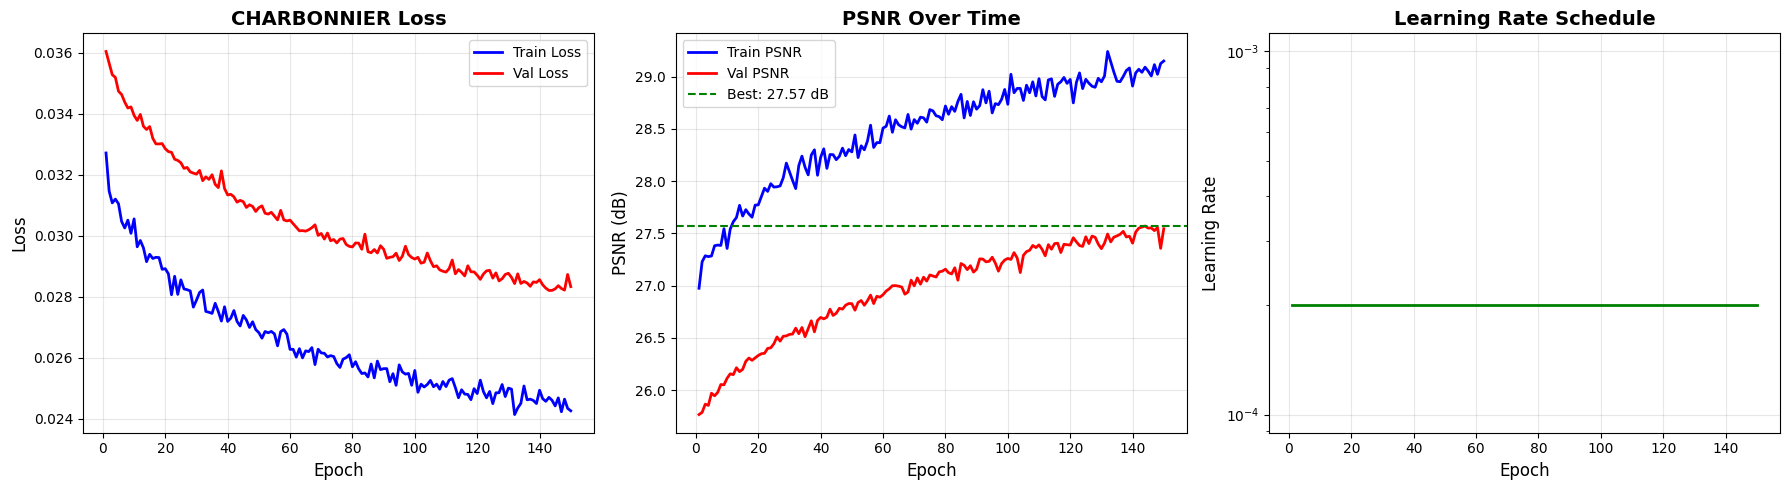

✓ Training curves saved to ./experiments/simple_unet_full/training_curves.png


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(f'{config.loss_type.upper()} Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PSNR
axes[1].plot(epochs_range, history['train_psnr'], 'b-', label='Train PSNR', linewidth=2)
axes[1].plot(epochs_range, history['val_psnr'], 'r-', label='Val PSNR', linewidth=2)
axes[1].axhline(y=best_psnr, color='g', linestyle='--', label=f'Best: {best_psnr:.2f} dB')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('PSNR (dB)', fontsize=12)
axes[1].set_title('PSNR Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(epochs_range, history['lr'], 'g-', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(experiment_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {experiment_dir}/training_curves.png")

## 11. Visualize Sample Predictions

Load the best model and visualize predictions on validation set.

In [11]:
# Load best model
checkpoint = torch.load(os.path.join(experiment_dir, 'best_model.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best PSNR: {checkpoint['best_psnr']:.2f} dB")

# Get a few validation samples
n_samples = 3
sample_indices = random.sample(range(len(val_dataset)), min(n_samples, len(val_dataset)))

fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5*n_samples))
if n_samples == 1:
    axes = axes.reshape(1, -1)

with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        blur, sharp = val_dataset[idx]
        
        # Add batch dimension and move to device
        blur_input = blur.unsqueeze(0).to(device)
        
        # Predict
        pred = model(blur_input).cpu().squeeze(0)
        
        # Calculate PSNR
        psnr_blur = calculate_psnr(blur.unsqueeze(0), sharp.unsqueeze(0)).item()
        psnr_pred = calculate_psnr(pred.unsqueeze(0), sharp.unsqueeze(0)).item()
        
        # Convert to numpy for visualization
        blur_np = blur.permute(1, 2, 0).numpy()
        sharp_np = sharp.permute(1, 2, 0).numpy()
        pred_np = pred.permute(1, 2, 0).numpy()
        
        # Clip to [0, 1] for visualization
        pred_np = np.clip(pred_np, 0, 1)
        
        # Calculate Error Map
        error_map = np.abs(pred_np - sharp_np).mean(axis=2) # Average over channels
        
        # Plot
        axes[i, 0].imshow(blur_np)
        axes[i, 0].set_title(f'Blur (PSNR: {psnr_blur:.2f} dB)', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pred_np)
        axes[i, 1].set_title(f'Prediction (PSNR: {psnr_pred:.2f} dB)', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(sharp_np)
        axes[i, 2].set_title(f'Ground Truth', fontsize=12)
        axes[i, 2].axis('off')
        
        # Error Map
        im = axes[i, 3].imshow(error_map, cmap='inferno', vmin=0, vmax=0.2)
        axes[i, 3].set_title(f'Error Map (L1: {error_map.mean():.4f})', fontsize=12)
        axes[i, 3].axis('off')
        plt.colorbar(im, ax=axes[i, 3], fraction=0.046, pad=0.04)
        
        improvement = psnr_pred - psnr_blur
        color = 'green' if improvement > 0 else 'red'
        axes[i, 1].text(0.5, -0.05, f'Δ PSNR: {improvement:+.2f} dB', 
                       transform=axes[i, 1].transAxes,
                       ha='center', fontsize=11, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(experiment_dir, 'sample_predictions.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Sample predictions saved to {experiment_dir}/sample_predictions.png")

Loaded best model from epoch 144
Best PSNR: 27.57 dB


✓ Sample predictions saved to ./experiments/simple_unet_full/sample_predictions.png
